In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import VAR
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error
from itertools import product
import xgboost as xgb
import warnings

In [3]:
df_mod = pd.read_csv("power_tetouan_city_modified.csv")

In [4]:
df_mod.head(10)

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption,mixed_type_col
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,NaN,34055.6962,16128.87538,20240.96386,624
1,1/1/2017 0:10,6.414,74.5,0.083,0.07,0.085,29814.68354,19375.07599,20131.08434,811
2,1/1/2017 0:20,6.313,74.5,0.08,0.062,0.1,29128.10127,19006.68693,19668.43373,unknown
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,bad
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.6962,17872.34043,18442.40964,879
5,1/1/2017 0:50,5.853,76.9,0.081,0.059,0.108,26624.81013,17416.41337,18130.12048,801
6,1/1/2017 1:00,5.641,77.7,0.08,0.048,0.096,25998.98734,16993.31307,17945.06024,unknown
7,1/1/2017 1:10,5.496,78.2,0.085,0.055,0.093,25446.07595,16661.39818,17459.27711,unknown
8,1/1/2017 1:20,5.678,78.1,0.081,0.066,0.141,24777.72152,16227.35562,17025.54217,924
9,1/1/2017 1:30,5.491,77.3,0.082,0.062,0.111,24279.49367,15939.20973,16794.21687,173


In [5]:
df_mod.describe()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption,mixed_type_col
count,52977,52880,52826,52846,52838,52849,52861,52839,52889,48162
unique,52036,5446,6291,1187,11915,11923,29720,31474,25057,1002
top,NAN,?,84.6,0.082,0.055,0.115,?,error,error,unknown
freq,21,57,182,2179,1488,1196,57,50,50,5521


In [140]:
df_mod.drop('mixed_type_col', axis=1, inplace=True)

## Convertir variables en numéricas

In [6]:
fecha_txt = pd.to_datetime(df_mod["DateTime"], errors="coerce")
num_cols = [c for c in df_mod.columns if c != "DateTime"]
y_df = df_mod[num_cols].apply(pd.to_numeric, errors="coerce")

df_mod2 = pd.concat([fecha_txt, y_df], axis=1)

In [7]:
df_mod = df_mod2.sort_values(by="DateTime").dropna(subset=["DateTime"]).set_index("DateTime")

In [8]:
df_mod.columns

Index(['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows',
       'diffuse flows', 'Zone 1 Power Consumption',
       'Zone 2  Power Consumption', 'Zone 3  Power Consumption',
       'mixed_type_col'],
      dtype='object')

## Análisis visual de los datos

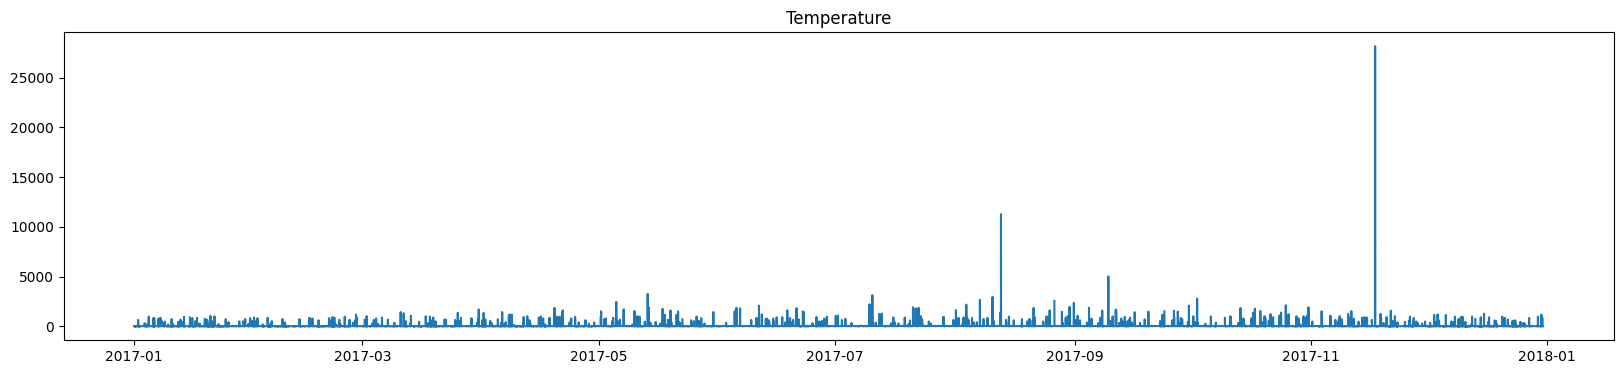

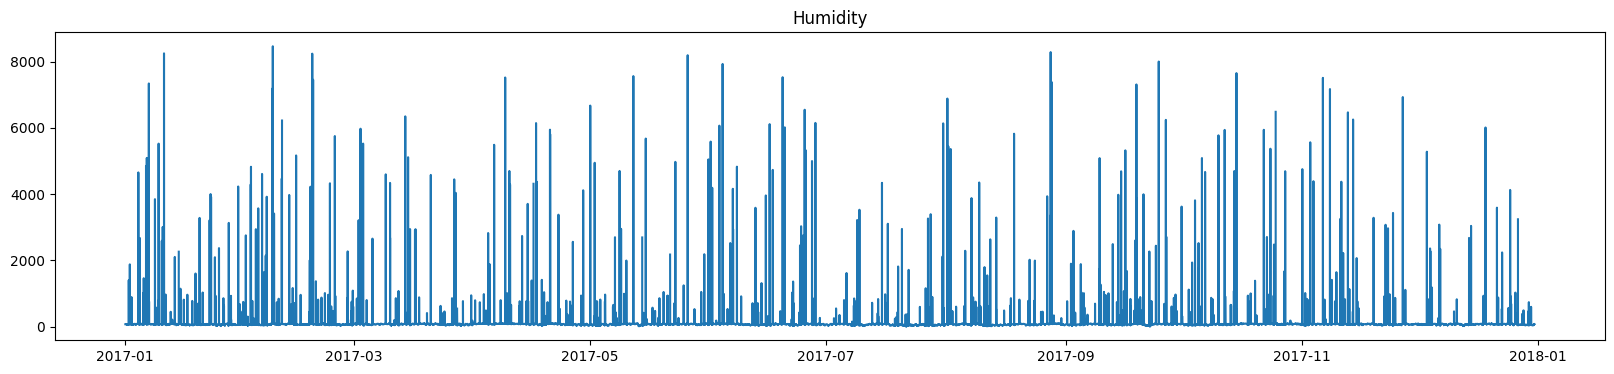

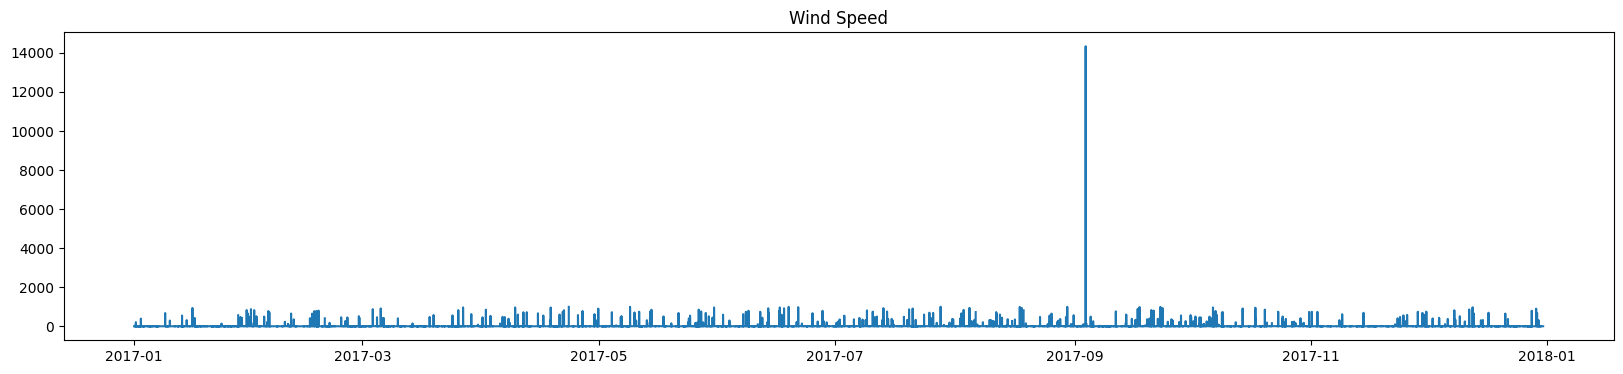

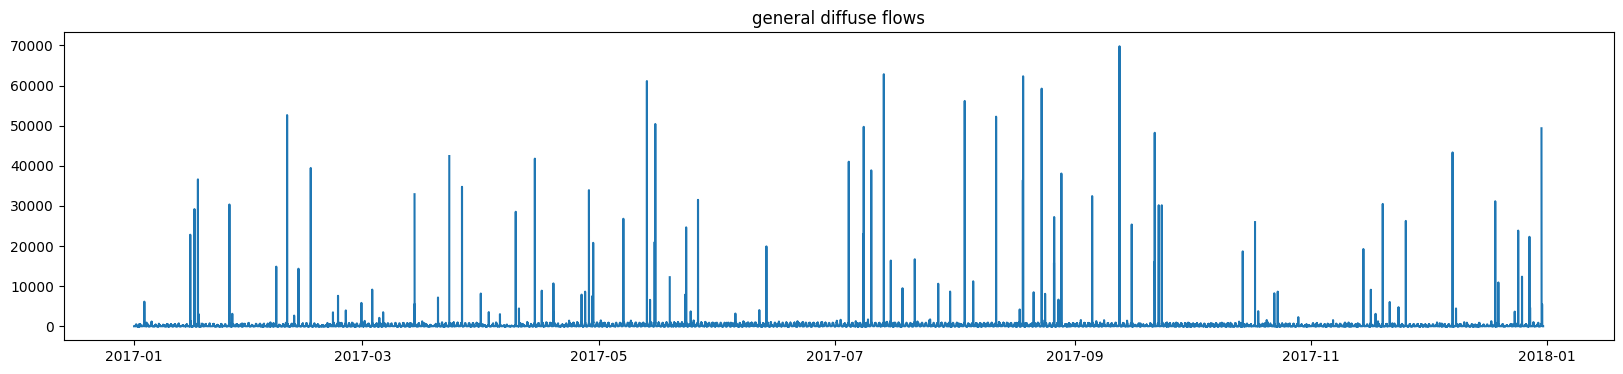

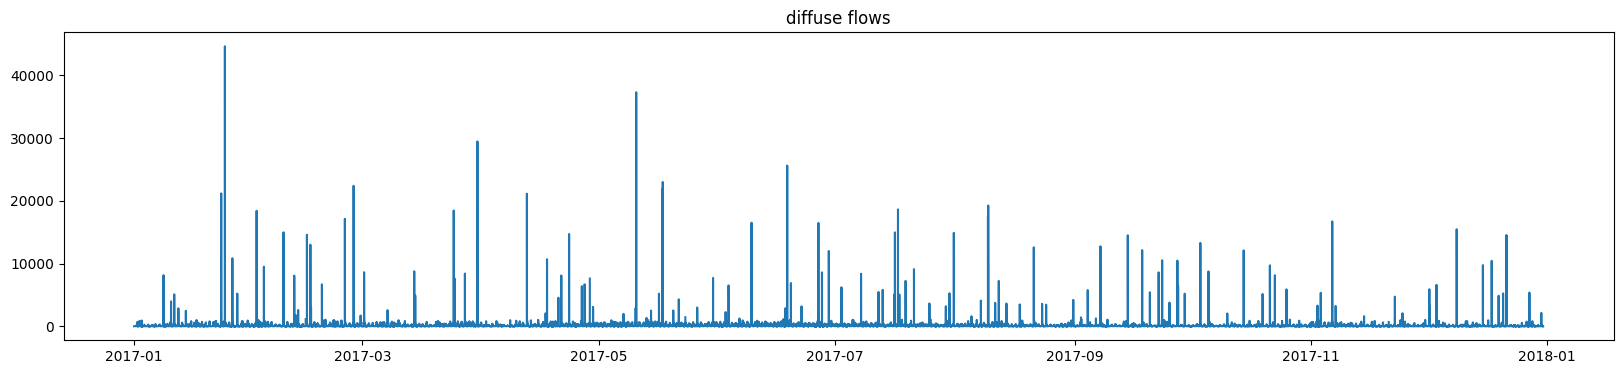

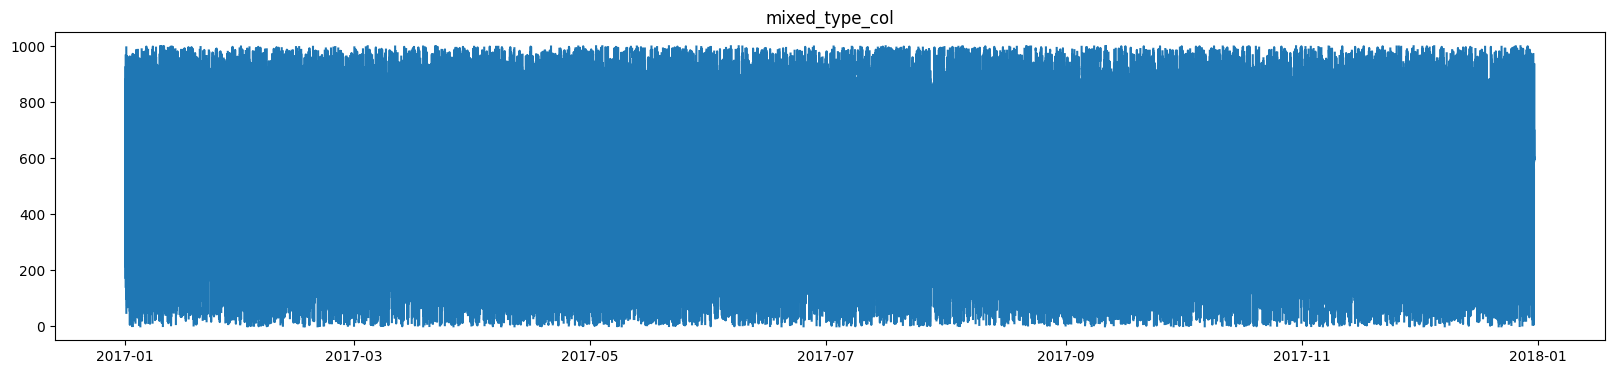

In [9]:
for c in ['Temperature', 'Humidity', 'Wind Speed','general diffuse flows', 'diffuse flows', 'mixed_type_col']:
    plt.figure(figsize=(20, 4))
    plt.plot(df_mod[[c]])
    plt.title(c)

## Tratamiento de datos nulos

In [10]:
df_mod.describe()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption,mixed_type_col
count,49560.000000,49523.000000,49554.000000,49519.000000,49541.000000,4.954900e+04,4.955800e+04,4.959600e+04,35159.000000
mean,27.435551,89.572671,5.495575,229.720847,100.452878,4.245753e+04,2.634412e+04,2.284480e+04,498.608464
std,165.418016,292.985329,78.600398,1265.907641,585.170054,2.504670e+05,8.890825e+04,8.344356e+04,289.635474
min,3.247000,11.340000,0.050000,0.004000,0.011000,1.389570e+04,8.560081e+03,5.935174e+03,0.000000
25%,14.460000,58.460000,0.078000,0.066000,0.122000,2.638570e+04,1.701199e+04,1.314970e+04,248.000000
50%,18.890000,70.100000,0.086000,6.524000,5.924000,3.233154e+04,2.086168e+04,1.644128e+04,496.000000
75%,23.060000,81.700000,4.915000,330.300000,103.900000,3.741797e+04,2.477690e+04,2.176193e+04,751.000000
max,28149.240000,8460.000000,14337.903000,69797.000000,44602.800000,4.559947e+07,2.958428e+06,3.566782e+06,999.000000


In [11]:
df_mod.count()

Temperature                  49560
Humidity                     49523
Wind Speed                   49554
general diffuse flows        49519
diffuse flows                49541
Zone 1 Power Consumption     49549
Zone 2  Power Consumption    49558
Zone 3  Power Consumption    49596
mixed_type_col               35159
dtype: int64

In [13]:
df_mod.isna().sum()/52977*100

Temperature                   1.398720
Humidity                      1.468562
Wind Speed                    1.410046
general diffuse flows         1.476112
diffuse flows                 1.434585
Zone 1 Power Consumption      1.419484
Zone 2  Power Consumption     1.402495
Zone 3  Power Consumption     1.330766
mixed_type_col               28.582215
dtype: float64

Dado que los datos nulos representan únicamente menos de 2% podriamos eliminarlos.

In [14]:
df_mod_cleaned = df_mod.dropna()

In [108]:
df_mod_cleaned[outliers==True].describe()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption,mixed_type_col
count,937.000000,937.000000,937.000000,937.000000,937.000000,9.370000e+02,9.370000e+02,9.370000e+02,937.000000
mean,245.536478,62.459723,6.569813,553.688038,190.201649,4.624440e+04,2.591096e+04,2.927606e+04,483.652081
std,566.406212,263.713465,53.347963,1757.405600,1007.086518,1.749068e+05,8.470140e+04,1.341396e+05,290.013978
min,10.250000,11.340000,0.064000,0.018000,0.052000,1.900800e+04,1.000610e+04,7.512289e+03,1.000000
25%,25.400000,28.550000,0.079000,145.500000,46.710000,3.164323e+04,1.932073e+04,1.560194e+04,230.000000
50%,32.800000,40.610000,4.905000,526.600000,91.100000,3.471755e+04,2.170031e+04,1.761231e+04,474.000000
75%,136.040000,61.100000,4.918000,751.000000,210.300000,3.778315e+04,2.547439e+04,2.586282e+04,728.000000
max,11269.440000,7518.000000,960.089000,48230.000000,29443.800000,3.386701e+06,2.405469e+06,2.582673e+06,999.000000


## Tratamiento de outliers

In [111]:
def sustituir_outliers_superior_mediana(df_ori, df_fin, col):
    data_array = np.array(df_ori[col])
    
    q1 = np.percentile(data_array, 25)
    q3 = np.percentile(data_array, 75)
    
    iqr = q3 - q1

    limite_superior = q3 + 2 * iqr    
    mediana = np.median(data_array)
    datos_sin_outliers = data_array.copy()
        
    outliers_superiores = datos_sin_outliers > limite_superior
    datos_sin_outliers[outliers_superiores] = mediana

    df_fin[col] = datos_sin_outliers
    
    return datos_sin_outliers

In [ ]:
df_mod_cleaned_w_outliers = df_mod_cleaned.copy()

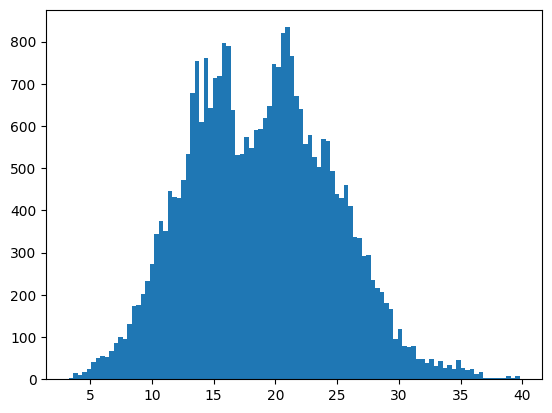

In [112]:
plt.hist(df_mod_cleaned.Temperature[df_mod_cleaned.Temperature<100], bins=100);

In [114]:
temp = sustituir_outliers_superior_mediana(df_mod_cleaned,df_mod_cleaned_w_outliers,'Temperature')

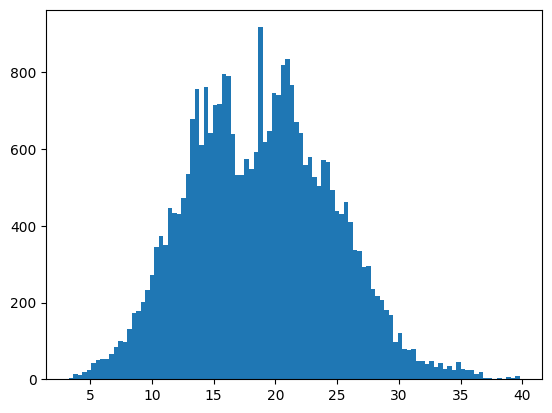

In [115]:
plt.hist(temp, bins=100);

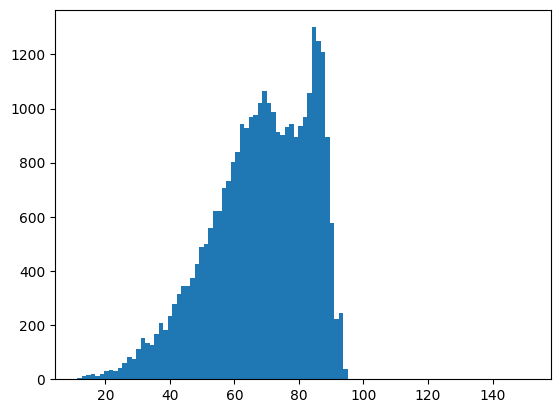

In [116]:
plt.hist(df_mod_cleaned.Humidity[df_mod_cleaned.Humidity<180], bins=100);

In [117]:
Humi = sustituir_outliers_superior_mediana(df_mod_cleaned,df_mod_cleaned_w_outliers,'Humidity')

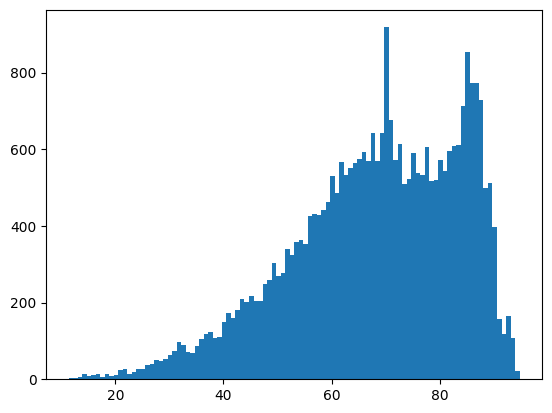

In [118]:
plt.hist(Humi, bins=100);

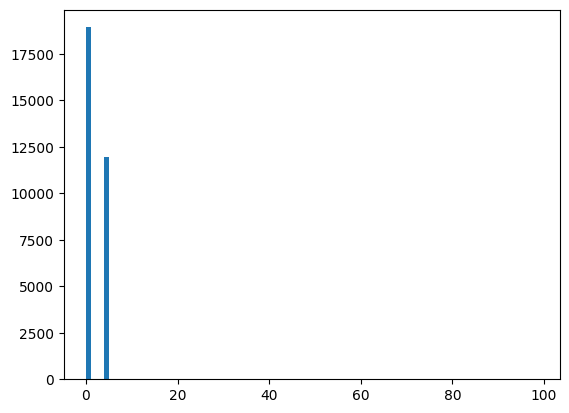

In [119]:
plt.hist(df_mod_cleaned[['Wind Speed']][df_mod_cleaned[['Wind Speed']]<100], bins=100);

In [120]:
Wind = sustituir_outliers_superior_mediana(df_mod_cleaned,df_mod_cleaned_w_outliers,'Wind Speed')

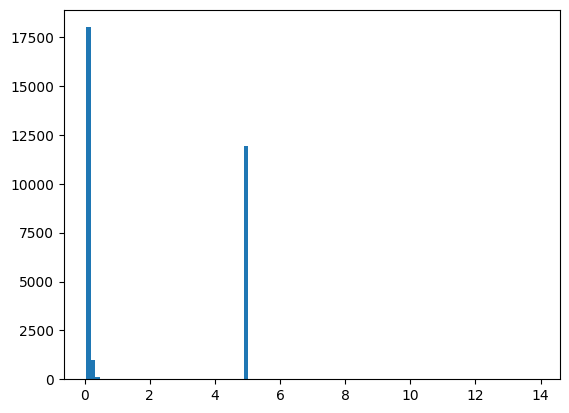

In [121]:
plt.hist(Wind, bins=100);

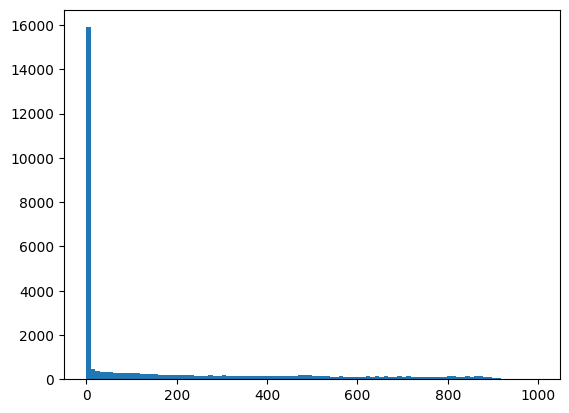

In [122]:
plt.hist(df_mod_cleaned[['general diffuse flows']][df_mod_cleaned[['general diffuse flows']]<1000], bins=100);

In [123]:
gdf = sustituir_outliers_superior_mediana(df_mod_cleaned,df_mod_cleaned_w_outliers,'general diffuse flows')

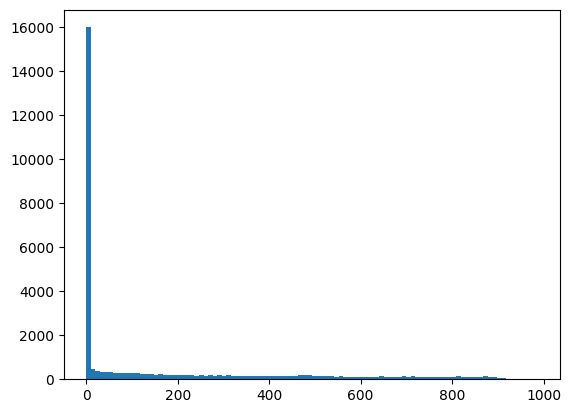

In [124]:
plt.hist(gdf, bins=100);

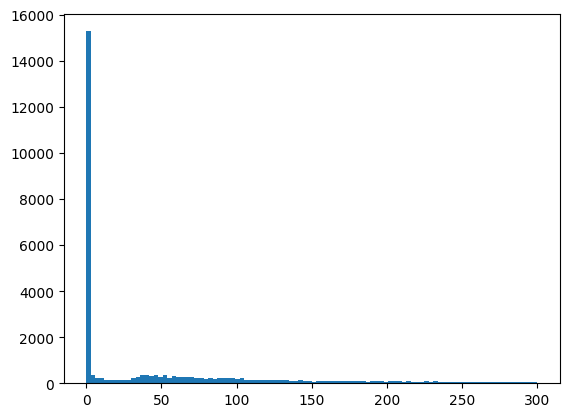

In [125]:
plt.hist(df_mod_cleaned[['diffuse flows']][df_mod_cleaned[['diffuse flows']]<300], bins=100);

In [126]:
dfs = sustituir_outliers_superior_mediana(df_mod_cleaned,df_mod_cleaned_w_outliers,'diffuse flows')

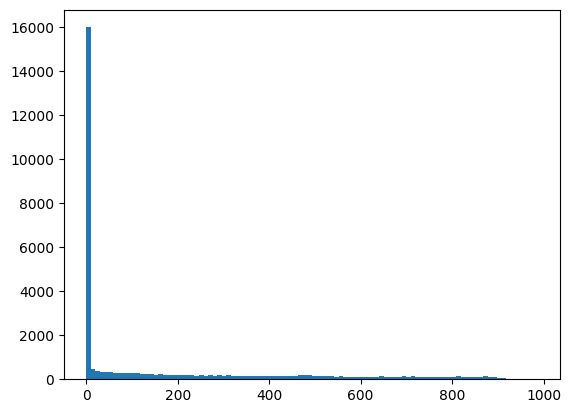

In [127]:
plt.hist(gdf, bins=100);

In [130]:
df_mod_cleaned_w_outliers.describe()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption,mixed_type_col
count,31241.000000,31241.000000,31241.000000,31241.000000,31241.000000,3.124100e+04,3.124100e+04,3.124100e+04,31241.000000
mean,18.850961,68.227529,1.956501,184.376256,48.828719,4.175465e+04,2.651794e+04,2.313372e+04,499.144618
std,5.784560,15.473401,2.351287,265.309365,74.350392,1.454336e+05,9.209121e+04,8.709070e+04,289.683089
min,3.247000,11.340000,0.050000,0.004000,0.011000,1.389570e+04,8.560081e+03,5.935174e+03,0.000000
25%,14.480000,58.350000,0.078000,0.066000,0.122000,2.635327e+04,1.702562e+04,1.316571e+04,249.000000
50%,18.930000,70.100000,0.086000,6.313000,5.831000,3.229277e+04,2.085248e+04,1.644387e+04,497.000000
75%,22.860000,81.200000,4.915000,325.100000,76.200000,3.741130e+04,2.479324e+04,2.178075e+04,752.000000
max,39.780000,94.800000,13.892000,986.000000,312.400000,4.661783e+06,2.958428e+06,3.566782e+06,999.000000


## Modelo predictivo

### Enfoque VAR

In [178]:
warnings.filterwarnings("ignore")

def encontrar_mejor_var(dataframe_series, lags, n_splits=5):

    best_score = float('inf')
    best_lag = 0

    print(f"Iniciando búsqueda del mejor rezago")

    for p in range(lags):
        scores = []
        
        tscv = TimeSeriesSplit(n_splits=n_splits)

        try:
            for train_index, test_index in tscv.split(dataframe_series):
                train_data = dataframe_series.iloc[train_index]
                test_data = dataframe_series.iloc[test_index]

                if len(train_data) < p:
                    continue
                    
                model = VAR(train_data)
                model_fit = model.fit(maxlags=p)
                
                lag_order = model_fit.k_ar
                forecast_input = train_data.values[-lag_order:]
                predictions = model_fit.forecast(y=forecast_input, steps=len(test_data))
                
                error = mean_squared_error(test_data.values, predictions)
                scores.append(error)

            mean_score = np.mean(scores)
            
            if mean_score < best_score:
                best_score = mean_score
                best_lag = p
                print(f"  -> Nuevo mejor rezago encontrado: {p} con RMSE = {np.sqrt(best_score):.4f}")

        except Exception as e:
            # print(f"    Rezago {p} falló: {e}")
            continue
    
    print("\nBúsqueda finalizada.")
#    print(f"Mejor número de rezagos (p): {best_lag}")
#    print(f"Mejor RMSE de Cross-Validation: {np.sqrt(best_score):.4f}")

    print("Entrenando modelo final con todos los datos...")
    final_model = VAR(dataframe_series)
    final_model_fit = final_model.fit(maxlags=best_lag)
    
    return final_model_fit, best_lag, np.sqrt(best_score)




In [172]:
train, test = train_test_split(df_mod_cleaned_w_outliers.drop('mixed_type_col', axis=1), test_size=0.05, shuffle=False)

In [234]:
mejor_modelo_var, mejor_rezago, mejor_rmse = encontrar_mejor_var(
    dataframe_series=train,
    lags=10,
    n_splits=5
)

print("\n--- Resumen del Mejor Modelo VAR Final ---")

forecast_input_final = train.values[-mejor_rezago:]
prediccion_futura = mejor_modelo_var.forecast(y=forecast_input_final, steps=10)

df_prediccion = pd.DataFrame(
    prediccion_futura, 
    index=pd.date_range(start=train.index[-1] + pd.Timedelta(minutes=10), periods=10, freq='10min'),
    columns=train.columns
)

print("\n--- Predicción multivariada para los próximos 10 días ---")

Iniciando búsqueda del mejor rezago
  -> Nuevo mejor rezago encontrado: 1 con RMSE = 69166.4207
  -> Nuevo mejor rezago encontrado: 5 con RMSE = 69165.8880

Búsqueda finalizada.
Entrenando modelo final con todos los datos...

--- Resumen del Mejor Modelo VAR Final ---

--- Predicción multivariada para los próximos 10 días ---


In [235]:
df_prediccion

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
2017-12-13 01:30:00,14.475078,61.532082,0.103551,-0.106160,4.581881,41789.579570,23950.543884,18781.389221
2017-12-13 01:40:00,14.378774,62.054251,0.106581,0.042618,6.636411,43010.418894,24903.728147,18214.606249
2017-12-13 01:50:00,14.267260,62.518584,0.120950,-1.309175,7.569917,40097.374393,25503.134156,18345.294368
2017-12-13 02:00:00,14.187939,62.961845,0.129955,-2.615900,8.842089,39398.067896,24408.361041,18382.856591
2017-12-13 02:10:00,14.118221,63.314198,0.139540,0.284424,10.389322,41171.265187,24673.884799,18335.906972
2017-12-13 02:20:00,14.039182,63.674431,0.149246,1.462001,11.568844,40687.769102,24572.141340,18454.764046
2017-12-13 02:30:00,13.971273,64.010807,0.158301,3.233180,12.667292,40640.156554,24541.833197,18417.323942
2017-12-13 02:40:00,13.909261,64.323436,0.167670,5.461689,13.670980,40443.333699,24524.827593,18330.006300
2017-12-13 02:50:00,13.851757,64.618667,0.176387,7.974356,14.606157,40365.203419,24460.302054,18270.121982
2017-12-13 03:00:00,13.796139,64.900877,0.185091,10.476711,15.495281,40286.412900,24387.858068,18258.745563


In [236]:
test[:10]

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
DateTime,,,,,,,,
2017-12-13 01:40:00,13.97,66.49,0.086,0.073,0.078,22357.41445,17099.72384,10193.517410
2017-12-13 01:50:00,13.38,71.30,0.083,0.055,0.115,22132.31939,17048.17429,10135.894360
2017-12-13 02:10:00,12.73,72.60,0.080,0.073,0.085,21706.46388,16433.26174,10222.328930
2017-12-13 02:30:00,13.16,60.21,0.079,0.048,0.085,21262.35741,16116.60018,9818.967587
2017-12-13 02:40:00,13.15,61.92,0.080,0.062,0.082,21238.02281,16079.77907,9778.631453
2017-12-13 02:50:00,12.94,63.05,0.078,0.084,0.100,21158.93536,15972.99785,9818.967587
2017-12-13 03:10:00,13.32,59.88,0.078,0.026,0.126,20733.07985,15807.30285,9565.426170
2017-12-13 03:20:00,13.52,55.04,0.080,0.055,0.126,20696.57795,15689.47530,9588.475390
2017-12-13 03:30:00,13.38,55.14,0.080,0.066,0.104,20562.73764,15663.70052,9565.426170


### Enfoque XG Boost

In [215]:
def crear_caracteristicas_alta_frecuencia(df, variable_objetivo):
    df_copy = df.copy()
    
    df_copy['hora'] = df_copy.index.hour
    df_copy['minuto'] = df_copy.index.minute
    df_copy['dia_de_semana'] = df_copy.index.dayofweek
    df_copy['dia_del_ano'] = df_copy.index.dayofyear
    
    pasos_por_hora = 6
    pasos_por_dia = 24 * pasos_por_hora

    df_copy[f'lag_{variable_objetivo}_1_hora'] = df_copy[variable_objetivo].shift(pasos_por_hora)
    df_copy[f'lag_{variable_objetivo}_24_horas'] = df_copy[variable_objetivo].shift(pasos_por_dia)

    df_copy[f'rolling_mean_{variable_objetivo}_1_hora'] = df_copy[variable_objetivo].shift(1).rolling(window=pasos_por_hora).mean()
    df_copy[f'rolling_mean_{variable_objetivo}_24_horas'] = df_copy[variable_objetivo].shift(1).rolling(window=pasos_por_dia).mean()
    
    df_copy = df_copy.dropna()
    
    X = df_copy.drop(columns=[variable_objetivo])
    y = df_copy[variable_objetivo]
    
    return X, y

In [229]:
def encontrar_mejor_xgboost_random(dataframe, variable_objetivo, param_dist, n_iter, n_splits=5):

    X, y = crear_caracteristicas_alta_frecuencia(dataframe, variable_objetivo)
    
    modelo_xgb = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', n_jobs=-1, random_state=42)
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    random_search = RandomizedSearchCV(
        estimator=modelo_xgb,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        verbose=1,
        random_state=1234
    )
    
    print(f"3. Iniciando la búsqueda aleatoria... (Probando {n_iter} combinaciones)")
    random_search.fit(X, y)
    
    print("\nBúsqueda finalizada.")
    
    best_score_rmse = -random_search.best_score_
    print(f"Mejor RMSE de Cross-Validation: {best_score_rmse:.4f}")

    best_model = random_search.best_estimator_
    
    return best_model, best_score_rmse

In [230]:
 param_distribuciones = {
        'n_estimators': randint(100, 1000),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.2),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4)
    }

In [231]:
mejor_modelo_random, mejor_rmse_random = encontrar_mejor_xgboost_random(
        dataframe=train[['Temperature','Humidity','Wind Speed','general diffuse flows','diffuse flows','Zone 1 Power Consumption']],
        variable_objetivo='Zone 1 Power Consumption',
        param_dist=param_distribuciones,
        n_iter=20
    )

3. Iniciando la búsqueda aleatoria... (Probando 20 combinaciones)
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Búsqueda finalizada.
Mejor RMSE de Cross-Validation: 157996.2908


In [232]:
def predecir_multiples_pasos_xgboost(modelo, df_historico, n_pasos, variable_objetivo, feature_creation_func):

    df_recursivo = df_historico.copy()
    predicciones = []

    for i in range(n_pasos):
        datos_para_features = df_recursivo.tail(200) 
        X_nuevas, _ = feature_creation_func(datos_para_features, variable_objetivo)
        
        X_a_predecir = X_nuevas.tail(1)
        
        prediccion_actual = modelo.predict(X_a_predecir)[0]
        predicciones.append(prediccion_actual)
        
        ultima_fecha_real = df_recursivo.index[-1]
        siguiente_fecha = ultima_fecha_real + pd.Timedelta(minutes=10)
        
        nueva_fila = {}
        nueva_fila[variable_objetivo] = prediccion_actual
        
        for col in df_recursivo.columns:
            if col != variable_objetivo:
                nueva_fila[col] = df_recursivo[col].iloc[-1]
        
        df_nueva_fila = pd.DataFrame([nueva_fila], index=[siguiente_fecha])
        df_recursivo = pd.concat([df_recursivo, df_nueva_fila])

    fechas_prediccion = pd.date_range(start=df_historico.index[-1] + pd.Timedelta(minutes=10), periods=n_pasos, freq='10T')
    serie_predicciones = pd.Series(predicciones, index=fechas_prediccion, name='predicciones_futuras')
    
    return serie_predicciones


In [233]:
predicciones_futuras = predecir_multiples_pasos_xgboost(
    modelo=mejor_modelo_random,
    df_historico=train[['Temperature','Humidity','Wind Speed','general diffuse flows','diffuse flows','Zone 1 Power Consumption']],
    n_pasos=10,
    variable_objetivo='Zone 1 Power Consumption',
    feature_creation_func=crear_caracteristicas_alta_frecuencia
)

print("\n-----------------------------------------")
print("Predicción Final para los próximos 10 pasos:")
print(predicciones_futuras)
print("-----------------------------------------")


-----------------------------------------
Predicción Final para los próximos 10 pasos:
2017-12-13 01:30:00    35548.152344
2017-12-13 01:40:00    35490.597656
2017-12-13 01:50:00    34401.386719
2017-12-13 02:00:00    34482.050781
2017-12-13 02:10:00    37527.250000
2017-12-13 02:20:00    39444.285156
2017-12-13 02:30:00    40526.898438
2017-12-13 02:40:00    43030.921875
2017-12-13 02:50:00    42173.964844
2017-12-13 03:00:00    41153.542969
Freq: 10T, Name: predicciones_futuras, dtype: float32
-----------------------------------------


In [199]:
test

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
DateTime,,,,,,,,
2017-12-13 01:40:00,13.970,66.49,0.086,0.073,0.078,22357.41445,1.709972e+04,10193.517410
2017-12-13 01:50:00,13.380,71.30,0.083,0.055,0.115,22132.31939,1.704817e+04,10135.894360
2017-12-13 02:10:00,12.730,72.60,0.080,0.073,0.085,21706.46388,1.643326e+04,10222.328930
2017-12-13 02:30:00,13.160,60.21,0.079,0.048,0.085,21262.35741,1.611660e+04,9818.967587
2017-12-13 02:40:00,13.150,61.92,0.080,0.062,0.082,21238.02281,1.607978e+04,9778.631453
...,...,...,...,...,...,...,...,...
2017-12-30 22:30:00,7.480,71.00,0.085,0.062,0.104,33776.42586,2.823075e+04,15546.698680
2017-12-30 22:40:00,7.390,71.20,0.079,0.066,0.100,33387.07224,2.781467e+04,15396.878750
2017-12-30 23:30:00,6.900,72.80,0.086,0.084,0.074,29590.87452,2.527769e+04,13806.482590
